## Introduction:
This notebook preforms parsing & cleansing the raw data of USA Washington state's house selling records in 2014 and makes prediction of property prices for the missing value in the dataset.

The notebook is written in Python 2.0, ipynb files.

There are 2 tasks includes:
1. Parsing the property sales data stored in “data.dat”
2. Auditing and cleansing the loaded data:
-----------------------------

# Task 1. Parsing the property sales data stored in “data.dat” --

## 1.1 Import libraries:

In [1]:
import pandas as pd
import numpy as np

import json
from pandas.io.json import json_normalize

import re

import matplotlib.pyplot as plt
from matplotlib.pyplot import *
%matplotlib inline
matplotlib.style.use("ggplot")

import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split

/anaconda3/envs/py27/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## 1.2 Examine and load the data into a Pandas DataFrame:

#### a. Parsing raw data:

In [4]:
# When we first examine the raw data in the file, we noted that the data have been store in a json formate in the file.
# Open the file and use 'JSON encoder and decoder' to parse the data.
filename = 'data.dat'
file = open(filename, mode='r')
data = json.load(file)

In [58]:
#Transform data from json format to pandas dataframe
dfA = pd.DataFrame.from_dict(json_normalize(data['houses']), orient='columns')
dfA.head()

,address,area.sqft_above,area.sqft_basement,area.sqft_living/sqft_lot,condition,date,floors,price,rooms,view,waterfront,yr_built,yr_renovated
0,"18810 Densmore Ave N, Shoreline, WA 98133, USA",1340,0,sqft_living/sqft_lot=1340\ 7912,3,20140502T000000,1.5,313000.0,Number of bathrooms: 1.5; Number of bedrooms: 3,0,0,1955,NaN
1,"709 W Blaine St, Seattle, WA 98119, USA",3370,280,sqft_living/sqft_lot=3650\ 9050,5,20140502T000000,2.0,2384000.0,Number of bathrooms: 2.5; Number of bedrooms: 5,4,0,1921,NaN
2,"26206-26214 143rd Ave SE, Kent, WA 98042, USA",1930,0,sqft_living/sqft_lot=1930\ 11947,4,20140502T000000,1.0,342000.0,Number of bathrooms: 2.0; Number of bedrooms: 3,0,0,1966,NaN
3,"857 170th Pl NE, Bellevue, WA 98008, USA",1000,1000,sqft_living/sqft_lot=2000\ 8030,4,20140502T000000,1.0,420000.0,Number of bathrooms: 2.25; Number of bedrooms: 3,0,0,1963,NaN
4,"9105 170th Ave NE, Redmond, WA 98052, USA",1140,800,sqft_living/sqft_lot=1940\ 10500,4,20140502T000000,1.0,550000.0,Number of bedrooms: 4; Number of bathrooms: 2.5,0,0,1976,NaN


#### b. Extract data for 'street', 'city', 'statezip' and 'country':

In [3]:
address = []
for item in dfA['address']:
    address.append(item.split(', '))

cols = ['street','city','statezip','country']
dfB = pd.DataFrame()
for col in cols:
    dfB[col]= [item[cols.index(col)] for item in address ]
dfB.head()

,street,city,statezip,country
0,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,709 W Blaine St,Seattle,WA 98119,USA
2,26206-26214 143rd Ave SE,Kent,WA 98042,USA
3,857 170th Pl NE,Bellevue,WA 98008,USA
4,9105 170th Ave NE,Redmond,WA 98052,USA


#### c. Extract data for 'sqft_living' and 'sqft_lot':

In [4]:
sqftLiving_sqftLot = []
for item in dfA['area.sqft_living/sqft_lot']:
    temp = re.findall(r'\d+', item)
    sqftLiving_sqftLot.append(temp)

cols2 = ['sqft_living','sqft_lot']
for col in cols2:
    dfB[col]= [item[cols2.index(col)] for item in sqftLiving_sqftLot ]
dfB.head()

,street,city,statezip,country,sqft_living,sqft_lot
0,18810 Densmore Ave N,Shoreline,WA 98133,USA,1340,7912
1,709 W Blaine St,Seattle,WA 98119,USA,3650,9050
2,26206-26214 143rd Ave SE,Kent,WA 98042,USA,1930,11947
3,857 170th Pl NE,Bellevue,WA 98008,USA,2000,8030
4,9105 170th Ave NE,Redmond,WA 98052,USA,1940,10500


#### d. Extract data for 'bedrooms' and 'bathrooms':

In [5]:
cols3 = ['bedrooms','bathrooms']
regex = [r'Number of bedrooms:\s(\d+\.?\d*)', r'Number of bathrooms:\s(\d+\.?\d*)']

n=0
for col in cols3:
    dfB[col]= [re.search(regex[n], item).group(1) for item in dfA['rooms']]
    n +=1                  
dfB.head()        

,street,city,statezip,country,sqft_living,sqft_lot,bedrooms,bathrooms
0,18810 Densmore Ave N,Shoreline,WA 98133,USA,1340,7912,3,1.5
1,709 W Blaine St,Seattle,WA 98119,USA,3650,9050,5,2.5
2,26206-26214 143rd Ave SE,Kent,WA 98042,USA,1930,11947,3,2.0
3,857 170th Pl NE,Bellevue,WA 98008,USA,2000,8030,3,2.25
4,9105 170th Ave NE,Redmond,WA 98052,USA,1940,10500,4,2.5


## 1.3  Combine extracted data to dataframe :

#### a. Concat two dataframe:

In [6]:
#concat two dataframe to a new dataframe 
df_raw = pd.concat([dfA, dfB], axis=1)

#rename two columns
df_raw.rename(columns = {'area.sqft_above':'sqft_above'}, inplace= True)
df_raw.rename(columns = {'area.sqft_basement':'sqft_basement'}, inplace= True)

#select required columns in the dataframe to create a new dataframe, rearrange the sequence of columns 
df_raw = df_raw[['date','price','bedrooms','bathrooms','sqft_living','sqft_lot','floors','waterfront','view',\
         'condition','sqft_above','sqft_basement','yr_built','yr_renovated','street', 'city', 'statezip', 'country']]
df_raw.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,20140502T000000,313000.0,3,1.5,1340,7912,1.5,0,0,3,1340,0,1955,NaN,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,20140502T000000,2384000.0,5,2.5,3650,9050,2.0,0,4,5,3370,280,1921,NaN,709 W Blaine St,Seattle,WA 98119,USA
2,20140502T000000,342000.0,3,2.0,1930,11947,1.0,0,0,4,1930,0,1966,NaN,26206-26214 143rd Ave SE,Kent,WA 98042,USA
3,20140502T000000,420000.0,3,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,NaN,857 170th Pl NE,Bellevue,WA 98008,USA
4,20140502T000000,550000.0,4,2.5,1940,10500,1.0,0,0,4,1140,800,1976,NaN,9105 170th Ave NE,Redmond,WA 98052,USA


#### b. Convert to proper datatypes:

In [7]:
df_raw['bedrooms'] = df_raw.bedrooms.astype(int)
df_raw['bathrooms'] = df_raw.bathrooms.astype(float)
df_raw['sqft_living'] = df_raw.sqft_living.astype(float)
df_raw['sqft_lot'] = df_raw.sqft_lot.astype(float)
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4601 entries, 0 to 4600
Data columns (total 18 columns):
date             4601 non-null object
price            4601 non-null float64
bedrooms         4601 non-null int64
bathrooms        4601 non-null float64
sqft_living      4601 non-null float64
sqft_lot         4601 non-null float64
floors           4601 non-null float64
waterfront       4601 non-null int64
view             4601 non-null int64
condition        4601 non-null int64
sqft_above       4601 non-null int64
sqft_basement    4601 non-null int64
yr_built         4601 non-null int64
yr_renovated     229 non-null float64
street           4601 non-null object
city             4601 non-null object
statezip         4601 non-null object
country          4601 non-null object
dtypes: float64(6), int64(7), object(5)
memory usage: 647.1+ KB


### Note:
The loaded data is now in dataframe df and ready for Task 2.

----------------------------------

# Task 2. Auditing and cleansing the loaded data --

#### Create a new dataframe by coping the original dataframe with raw data:

In [8]:
df = df_raw.copy()
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,20140502T000000,313000.0,3,1.50,1340.0,7912.0,1.5,0,0,3,1340,0,1955,NaN,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,20140502T000000,2384000.0,5,2.50,3650.0,9050.0,2.0,0,4,5,3370,280,1921,NaN,709 W Blaine St,Seattle,WA 98119,USA
2,20140502T000000,342000.0,3,2.00,1930.0,11947.0,1.0,0,0,4,1930,0,1966,NaN,26206-26214 143rd Ave SE,Kent,WA 98042,USA
3,20140502T000000,420000.0,3,2.25,2000.0,8030.0,1.0,0,0,4,1000,1000,1963,NaN,857 170th Pl NE,Bellevue,WA 98008,USA
4,20140502T000000,550000.0,4,2.50,1940.0,10500.0,1.0,0,0,4,1140,800,1976,NaN,9105 170th Ave NE,Redmond,WA 98052,USA


#### Have a look at variables:

In [9]:
catvars = ['date','country', 'statezip' , 'city', 'bedrooms','bathrooms', 'floors','waterfront','view', 'condition'] 
for var in catvars:
    print var
    print df[var].unique()
    print ''

date
[u'20140502T000000' u'20140503T000000' u'20140504T000000'
 u'20140505T000000' u'20140506T000000' u'20140507T000000'
 u'20140508T000000' u'20140509T000000' u'20140510T000000'
 u'20140511T000000' u'20140512T000000' u'20140513T000000'
 u'20140514T000000' u'20140515T000000' u'20140516T000000'
 u'20140517T000000' u'20140518T000000' u'20140519T000000'
 u'20140520T000000' u'20140521T000000' u'20140522T000000'
 u'20140523T000000' u'20140524T000000' u'20140525T000000'
 u'20140526T000000' u'20140527T000000' u'20140528T000000'
 u'20140529T000000' u'20140530T000000' u'20140531T000000'
 u'20140601T000000' u'20140602T000000' u'20140603T000000'
 u'20140604T000000' u'20140605T000000' u'20140606T000000'
 u'20140607T000000' u'20140608T000000' u'20140609T000000'
 u'20140610T000000' u'20140611T000000' u'20140612T000000'
 u'20140613T000000' u'20140614T000000' u'20140615T000000'
 u'20140616T000000' u'20140617T000000' u'20140618T000000'
 u'20140619T000000' u'20140620T000000' u'20140621T000000'
 u'201406

### Note: 
Seems like there are some mistakes in:
* 'date'
* 'city'
* 'bathrooms'

## 2.1 Lexical errors, e.g., typos and spelling mistakes:
### 2.1-1 City Name:

#### a. Visually check city names with its occurrence. 
* Name appears no more than 2 times is considered to have high chance of typos and spelling mistakes.

In [10]:
city_counts = df.city.value_counts()
city_counts_sortByName = (city_counts.sort_index())
print city_counts_sortByName[0:30]
print city_counts_sortByName[30:]

Algona                   5
Auburn                 174
Auburnt                  1
Beaux Arts Village       1
Belleview                1
Bellevue               284
Bellvue                  1
Black Diamond            9
Bothell                 33
Burien                  74
Carnation               21
Clyde Hill              11
Coronation               1
Covington               43
Des Moines              58
Duvall                  42
Enumclaw                28
Fall City               11
Federal Way            148
Inglewood-Finn Hill      1
Issaguah                 1
Issaquah               186
Kenmore                 66
Kent                   185
Kirkland               186
Kirklund                 1
Lake Forest Park        36
Maple Valley            96
Medina                  11
Mercer Island           86
Name: city, dtype: int64
Milton                2
Newcastle            33
Normandy Park        18
North Bend           50
Pacific               6
Preston               2
Ravensdale           

###  Note:
Compare city name appears no more than two times with a similar name appears many times, founding out the typo mistakes as below:
*  (Typo)  -> (Correct)
* Auburnt (1) -> Auburn (174)
* Belleview (1) -> Bellevue (284)
* Bellvue (1)  -> Bellevue (284)
* Issaguah (1) -> Issaquah (186)
* Kirklund (1) -> Kirkland (186)
* Redmonde (1) -> Redmond  (232)    
* Redmund (1) -> Redmond (232)     
* Samamish (1) -> Sammamish (174)
* Seaattle (1) -> Seattle (1569)
* Seatle (1) -> Seattle (1569)
* Snogualmie (1)-> Snoqualmie (70)
* Sureline (1) -> Shoreline (122)
* Woodenville (2) -> Woodinville (113)

* Coronation (1)-> Carnation (21)

In [11]:
#confirm 'Coronation' shall be 'Carnation':
df.city[df['statezip'] == 'WA 98014'].value_counts()

Carnation     21
Coronation     1
Name: city, dtype: int64

#### b. Replace the wrong city names with the correct one:

In [12]:
df['city'].replace({   'Auburnt':'Auburn', \
                       'Belleview':'Bellevue', \
                       'Bellvue':'Bellevue', \
                       'Coronation':'Carnation', \
                       'Issaguah':'Issaquah', \
                       'Kirklund':'Kirkland', \
                       'Redmonde':'Redmond', \
                       'Redmund':'Redmond', \
                       'Samamish':'Sammamish', \
                       'Seaattle':'Seattle', \
                       'Seatle':'Seattle', \
                       'Snogualmie':'Snoqualmie', \
                       'Sureline':'Shoreline', \
                       'Woodenville':'Woodinville'}, inplace=True)

## 2.2 Inconsistency, e.g., inhomogeneity in values and types in representing the same data
### 2.2-1 City Name:
When checking the city names, we also noted that there is some city name are inconsistency in the dataset.

* sammamish -> Sammamish 
* seattle  -> Seattle 
* redmond  -> Redmond 
* auburn -> Auburn

#### a. Revise 'city' names with upper case in the first character to fix the data  inconsistency:

In [13]:
df['city'].replace({   'sammamish':'Sammamish', \
                       'seattle':'Seattle', \
                       'redmond':'Redmond', \
                       'auburn':'Auburn'}, inplace=True)
df.city.value_counts()

Seattle                1573
Renton                  293
Bellevue                286
Redmond                 235
Kirkland                187
Issaquah                187
Kent                    185
Sammamish               176
Auburn                  176
Federal Way             148
Shoreline               123
Woodinville             115
Maple Valley             96
Mercer Island            86
Burien                   74
Snoqualmie               71
Kenmore                  66
Des Moines               58
North Bend               50
Covington                43
Duvall                   42
Lake Forest Park         36
Newcastle                33
Bothell                  33
SeaTac                   29
Vashon                   29
Tukwila                  29
Enumclaw                 28
Carnation                22
Normandy Park            18
Fall City                11
Clyde Hill               11
Medina                   11
Black Diamond             9
Ravensdale                7
Pacific             

### Note:  
* All problem in 'city' name have been fixed.

## 2.3 Irregularities, e.g., abnormal data values and data formats

### 2.3-1 'date' formats:
#### a. Use regular expression to extract abnormal data values and formats:

In [14]:
regex = r'''(?x)
        (?:(?:(?:\d{2})?\d{2})
        (?:(?:(?:0[469]|11)(?:30|[12][0-9]|0[1-9]))|
        (?:(?:0[13578]|1[02])(?:3[01]|[12][0-9]|0[1-9]))|
        (?:(?:0?2)(?:[12][0-9]|0?[1-9]))))
        T000000'''
df[~df.date.str.match(regex)]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
4334,20140631T000000,248000.0,3,1.00,950.0,9400.0,1.0,0,0,4,950,0,1954,NaN,3920 153rd Ave SE,Bellevue,WA 98006,USA
4335,23052014T000000,505000.0,3,2.25,1670.0,1596.0,2.0,0,0,3,1220,450,2002,NaN,3019 30th Ave W,Seattle,WA 98199,USA


#### b. Fix problems of  abnormal data values and formats in 'date':

In [15]:
df.set_value(4334, 'date', '20140630T000000') #20140631T000000 -> 20140630T000000
df.set_value(4335, 'date', '20140523T000000') #23052014T000000 -> 20140523T000000
df.iloc[[4334,4335]]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
4334,20140630T000000,248000.0,3,1.00,950.0,9400.0,1.0,0,0,4,950,0,1954,NaN,3920 153rd Ave SE,Bellevue,WA 98006,USA
4335,20140523T000000,505000.0,3,2.25,1670.0,1596.0,2.0,0,0,3,1220,450,2002,NaN,3019 30th Ave W,Seattle,WA 98199,USA


### T2.3-2 'bathrooms'	formats: 
(The value of which can be either an integer or a fraction ending with .25, .5, and .75. )
#### a. List out the Irregularities of  'bathrooms' value:

In [16]:
df[df.bathrooms % 0.25 != 0]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
4329,20140506T000000,518000.0,3,1.05,1430.0,8000.0,1.0,0,0,4,1430,0,1956,NaN,2527 154th Ave SE,Bellevue,WA 98007,USA
4330,20140509T000000,525000.0,3,2.55,2030.0,6970.0,2.0,0,0,4,2030,0,1991,NaN,3913 255th Pl SE,Issaquah,WA 98029,USA
4331,20140624T000000,236000.0,4,2.57,2000.0,5827.0,2.0,0,0,3,2000,0,1997,NaN,26546 236th Pl SE,Maple Valley,WA 98038,USA
4332,20140610T000000,278500.0,4,2.30,1940.0,6206.0,2.0,0,0,3,1940,0,1990,NaN,32900 19th Ave SW,Federal Way,WA 98023,USA
4333,20140623T000000,205425.0,2,1.70,880.0,6780.0,1.0,0,0,4,880,0,1945,NaN,11440 69th Pl S,Seattle,WA 98178,USA


### Note:  
* For the Irregularities value of 'bathrooms', there is two methods to correct the data value,
* We can either by making prediction of the value of bathrooms by others considered high correlation features such as floors and bathrooms in this dataset.
* Or, we can directly perform nearest round the value to the closest value end with .0 .25, .5, and .75.

#### b. Correlation Coefficient for 'bathrooms', 'floors' and 'bedrooms'  

In [17]:
print(df[['bathrooms','bedrooms','floors']].corr())

           bathrooms  bedrooms    floors
bathrooms   1.000000  0.545834  0.486510
bedrooms    0.545834  1.000000  0.177788
floors      0.486510  0.177788  1.000000


#### c. Predict bathrooms by feature 'bedrooms' and 'floors'

In [18]:
lm = LinearRegression()
ss = StandardScaler()
Xstd = ss.fit_transform(df[['bedrooms','floors']])
dfXstd = pd.DataFrame(Xstd, columns=['bedrooms','floors'])
dfXstd 
Xstd = dfXstd.drop([4329,4330,4331,4332,4333], axis=0)
y = df['bathrooms'].drop([4329,4330,4331,4332,4333], axis=0)
lm.fit(Xstd, y)
print('Predicted bathrooms with 1.05: {0:.1f}'.format(lm.predict(dfXstd.iloc[4329].reshape(1,-1))[0]))
print('Predicted bathrooms with 2.55: {0:.1f}'.format(lm.predict(dfXstd.iloc[4330].reshape(1,-1))[0]))
print('Predicted bathrooms with 2.57: {0:.1f}'.format(lm.predict(dfXstd.iloc[4331].reshape(1,-1))[0]))
print('Predicted bathrooms with 2.30: {0:.1f}'.format(lm.predict(dfXstd.iloc[4332].reshape(1,-1))[0]))
print('Predicted bathrooms with 1.70: {0:.1f}'.format(lm.predict(dfXstd.iloc[4333].reshape(1,-1))[0]))

Predicted bathrooms with 1.05: 1.7
Predicted bathrooms with 2.55: 2.3
Predicted bathrooms with 2.57: 2.7
Predicted bathrooms with 2.30: 2.7
Predicted bathrooms with 1.70: 1.3


### Note:  
* Results of the predict value of the bathrooms seems no good as the value are not end or even close with .0 .25, .5, and .75. 
* Hence, we decided to directly perform nearest round the value to the closest value end with .0 .25, .5, and .75.

#### d. Nearest round 'bathrooms' values to the cloeset value end with .0 .25, .5, and .75. to fix the Irregularities problem in 'bathrooms'

In [19]:
df['bathrooms']= [ round (item*4)/4 for item in df['bathrooms']]
df.iloc[[4329,4330,4331,4332,4333]]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
4329,20140506T000000,518000.0,3,1.00,1430.0,8000.0,1.0,0,0,4,1430,0,1956,NaN,2527 154th Ave SE,Bellevue,WA 98007,USA
4330,20140509T000000,525000.0,3,2.50,2030.0,6970.0,2.0,0,0,4,2030,0,1991,NaN,3913 255th Pl SE,Issaquah,WA 98029,USA
4331,20140624T000000,236000.0,4,2.50,2000.0,5827.0,2.0,0,0,3,2000,0,1997,NaN,26546 236th Pl SE,Maple Valley,WA 98038,USA
4332,20140610T000000,278500.0,4,2.25,1940.0,6206.0,2.0,0,0,3,1940,0,1990,NaN,32900 19th Ave SW,Federal Way,WA 98023,USA
4333,20140623T000000,205425.0,2,1.75,880.0,6780.0,1.0,0,0,4,880,0,1945,NaN,11440 69th Pl S,Seattle,WA 98178,USA


## 2.4 Violations of the Integrity constraint
### 2.4-1 'sqft_living' shall equal to  'sqft_above' + 'sqft_basement 
#### a. Find if any record violates the Integrity constraint ('sqft_living' = 'sqft_above' + 'sqft_basement' ):

In [20]:
#list out records for 'sqft_living' not equal to 'sqft_above' + 'sqft_basement' 
df[df['sqft_living'] != df['sqft_above'] + df['sqft_basement']]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
4338,20140710T000000,670000.0,3,2.5,1280.0,1438.0,2.0,0,0,3,1280,1420,2003,NaN,746 Boylston Ave E,Seattle,WA 98102,USA
4339,20140701T000000,202000.0,1,1.0,890.0,833.0,1.0,0,0,4,590,0,1926,NaN,701-711 26th Ave,Seattle,WA 98122,USA


#### b. Fix problems of Integrity constraint for 'sqft_living' = 'sqft_above' + 'sqft_basement':

In [21]:
df.set_value(4338, 'sqft_living', df.iloc[4338]['sqft_above']+ df.iloc[4338]['sqft_basement'])
df.set_value(4339, 'sqft_basement', df.iloc[4339]['sqft_living']- df.iloc[4339]['sqft_above'])
df.loc[[4338,4339]]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
4338,20140710T000000,670000.0,3,2.5,2700.0,1438.0,2.0,0,0,3,1280,1420,2003,NaN,746 Boylston Ave E,Seattle,WA 98102,USA
4339,20140701T000000,202000.0,1,1.0,890.0,833.0,1.0,0,0,4,590,300,1926,NaN,701-711 26th Ave,Seattle,WA 98122,USA


### 2.4-2  'yr_renovated' shall not be earlier than 'yr_built'
#### a. List out the records violates the data integrity constraint in 'yr_renovated' with  'yr_built':

In [22]:
df[df.yr_built > df.yr_renovated]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
4340,20140502T000000,440000.0,4,2.25,2160.0,8119.0,1.0,0,0,3,1080,1080,1966,1913.0,12211 SE 65th St,Bellevue,WA 98006,USA
4341,20140526T000000,690000.0,4,2.50,2700.0,8810.0,2.0,0,0,3,2700,0,2004,2003.0,11659 168th Ct NE,Redmond,WA 98052,USA
4342,20140508T000000,375000.0,6,2.25,3206.0,5793.0,2.0,0,0,3,3206,0,2012,1912.0,25921-25929 35th Pl S,Kent,WA 98032,USA
4345,20140522T000000,850000.0,4,3.25,3090.0,6744.0,2.0,0,4,3,3090,0,2013,1923.0,19117-19123 Richmond Beach Dr NW,Shoreline,WA 98177,USA


#### b. See if any relevant records with the same street value in the dataset that we can refer to the correct value of 'yr_built' and 'yr_renovated':

In [23]:
street =set(df.street[df.yr_built > df.yr_renovated])
street 
df[df.street.isin(street)]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
4340,20140502T000000,440000.0,4,2.25,2160.0,8119.0,1.0,0,0,3,1080,1080,1966,1913.0,12211 SE 65th St,Bellevue,WA 98006,USA
4341,20140526T000000,690000.0,4,2.50,2700.0,8810.0,2.0,0,0,3,2700,0,2004,2003.0,11659 168th Ct NE,Redmond,WA 98052,USA
4342,20140508T000000,375000.0,6,2.25,3206.0,5793.0,2.0,0,0,3,3206,0,2012,1912.0,25921-25929 35th Pl S,Kent,WA 98032,USA
4345,20140522T000000,850000.0,4,3.25,3090.0,6744.0,2.0,0,4,3,3090,0,2013,1923.0,19117-19123 Richmond Beach Dr NW,Shoreline,WA 98177,USA


### Note:  
* As there is no other records with the same street name, we cannot have any reference of both value 'df.yr_built' and 'df.yr_renovated'for the correction of the 4 wrong record with df.yr_built > df.yr_renovated.
* However, we noted that when data/record be input to the database system, sometime the record person will key in the data wrongly by input data to the wrong columns. In this case, we assume that the 4 wrong records result from recorder input the year renovated to 'df.yr_built' while year built be input to f.yr_renovated.
* Hence, we will fix the problem by swapping the data in 'yr_built' with data in 'yr_renovated' for these 4 records.

#### c. Fix the problem by swapping the data in 'yr_built' with data in 'yr_renovated' for these 4 records:

In [24]:
#swap the values of 'yr_built' with the values of 'yr_renovated' for these 4 records and create a new dataframe
df.loc[df.yr_built > df.yr_renovated,['yr_built','yr_renovated']]\
= df.loc[df.yr_built > df.yr_renovated,['yr_renovated','yr_built']].values

#check if the problem fixed
df[df.yr_built > df.yr_renovated]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country


### 2.4-3 Other data problems?
(e.g. Can a property has its square footage of interior living space bigger than square footage of the land space?

In [25]:
#list out records with 'sqft_living' > 'sqft_lot'
df[df['sqft_living'] > df['sqft_lot']]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
22,20140502T000000,626000.0,3,2.25,1750.0,1572.0,2.5,0,0,3,1470,280,2005,NaN,3140 Franklin Ave E,Seattle,WA 98102,USA
48,20140502T000000,445700.0,3,2.50,1270.0,1180.0,3.0,0,0,3,1270,0,2001,NaN,2640 NW 56th St,Seattle,WA 98107,USA
59,20140502T000000,295000.0,2,2.50,1630.0,1368.0,2.0,0,0,3,1280,350,2009,NaN,5944-6082 Delridge Way SW,Seattle,WA 98106,USA
75,20140505T000000,531000.0,2,3.00,1270.0,1175.0,2.0,0,0,3,1110,160,2000,NaN,1411 N 48th St,Seattle,WA 98103,USA
88,20140505T000000,405000.0,2,3.00,1410.0,1240.0,2.0,0,0,3,1140,270,2006,NaN,9126 45th Ave SW,Seattle,WA 98136,USA
98,20140505T000000,406100.0,3,2.25,1410.0,1332.0,3.0,0,0,3,1410,0,2005,NaN,8536 Interlake Ave N,Seattle,WA 98103,USA
145,20140505T000000,415000.0,3,2.25,1620.0,998.0,2.5,0,0,3,1540,80,2010,NaN,935 4th Ave NE,Issaquah,WA 98029,USA
146,20140505T000000,416286.0,3,2.50,1408.0,989.0,3.0,0,0,3,1408,0,2005,NaN,7809 12th Ave NE,Seattle,WA 98115,USA
149,20140505T000000,419190.0,2,2.50,1590.0,1426.0,2.0,0,0,3,1590,0,2014,NaN,1273 NE Hickory Ln,Issaquah,WA 98029,USA
181,20140506T000000,460000.0,2,2.25,1230.0,929.0,2.0,0,0,3,1020,210,2004,NaN,100 24th Ave E,Seattle,WA 98112,USA


### Note: 
* There are 172 records with its 'sqft_living' > 'sqft_lot'.
* Some may say that square footage of interior living space cannot bigger than square footage of the land space.
* However, in my opinion is that it is possible for a property has its square footage of interior living space bigger than square footage of the land space, as the property may have multiple floors. Property have multiple floors may have the sum of the total living space larger than its land area.
* In addition, we can have a solid confirmation for the correctness of 'sqft_living' values for these 172 by comparing the it to the sum of 'sqft_above' and 'sqft_basement'.

## 2.5 Duplications

### 2.5-1 Record have same value for all columns:

In [26]:
df[df.duplicated(keep=False)]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
4336,20140522T000000,657500.0,3,2.5,2670.0,10496.0,2.0,0,0,3,2670,0,1989,NaN,1917 235th Ct NE,Sammamish,WA 98074,USA
4337,20140522T000000,657500.0,3,2.5,2670.0,10496.0,2.0,0,0,3,2670,0,1989,NaN,1917 235th Ct NE,Sammamish,WA 98074,USA


### Note:  
* Record 4336 and 4337 have same value for all the columns. Duplication found.
* The duplication need to be removed from the dataset.

#### a. Delete record 4337 for fixing the duplication problem:

In [27]:
df.drop([4337], inplace = True) 

### 2.5-2 Any other duplication?

In [28]:
df[df.duplicated(['price','street'], keep=False)]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
2271,20140610T000000,399950.0,2,1.0,710.0,1157.0,2.0,0,0,4,710,0,1943,NaN,2358 Fairview Ave E,Seattle,WA 98102,USA
2350,20140611T000000,399950.0,2,1.0,710.0,1131.0,2.0,0,0,4,710,0,1943,NaN,2358 Fairview Ave E,Seattle,WA 98102,USA


### Note:  
* Record 2271 and 2350 have all the same value except 'date' with one day difference and 'sqft_lot' with 26 square foot difference. 
* We cannot say it there is a duplication of the record, as it might be two units belong to a townhouse that be sold in different day with the same price. And it is reasonable for units in a townhouse have square foot of living space different from each other.
* Seems like there is no other duplication exist in the dataset.

## 2.6 Outliers detection

#### a. Check for extreme outliers or nonsensical values by using boxplot for each numerical data:

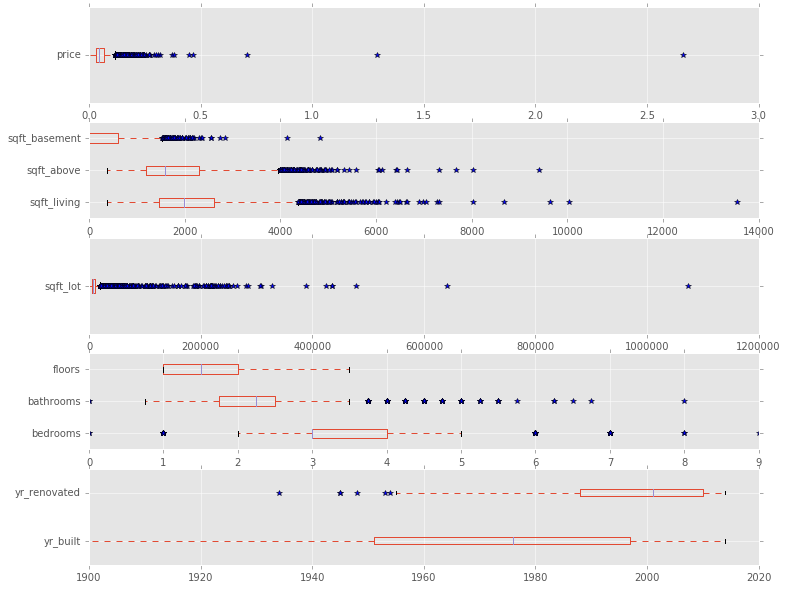

In [29]:
f,ax = plt.subplots(5, 1, figsize=(12,10))

df.price.plot(kind='box', vert=False, sym='*', ax=ax[0])

sqfts = [col for col in df.columns if 'sqft' in col and 'lot' not in col]
df[sqfts].plot(kind='box', vert=False, sym='*', ax=ax[1])
df[[col for col in df.columns if 'sqft' in col and 'lot' in col]].plot(kind='box', vert=False, sym='*', ax=ax[2])
df[['bedrooms', 'bathrooms', 'floors']].plot(kind='box', vert=False, sym='*', ax=ax[3])
df[[col for col in df.columns if 'yr' in col]].plot(kind='box', vert=False, sym='*', ax=ax[4])

### Note:  
For 'price':
* There are 2 records with high price compared to the rest of records.
* Some records have zero value in 'price' which is not reasonable, as propery cannot be sold with zero value. Records with zero value in 'price' are the missing value records that we have to deal with them in Missing value section in the last part.
* At this stage, we temporarily remove the records with missing value in 'price' first, as we will not contain those missing value data when founding the outliers of the record in 'price'.

For 'sqft_lot':
* There are two records with large land space compared to the rest of records.

We need to proceed some further examination to know if those records are indeed outliers.

#### b. Create a new dataframe without records with zero value in 'price':

In [30]:
df_priceDropNa = df[df.price > 0]
df_priceDropNa.tail()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
4348,20140508T000000,2110000.0,4,1.00,2100.0,9200.0,1.0,0,0,3,1050,1050,1959,NaN,14070 Military Rd S,Tukwila,WA 98168,USA
4349,20140505T000000,2199900.0,4,1.50,1120.0,5427.0,1.0,0,0,3,1120,0,1969,2014.0,19009-19021 SE 266th St,Covington,WA 98042,USA
4350,20140514T000000,188000.0,4,2.75,3260.0,19542.0,1.0,0,0,4,2170,1090,1968,NaN,1525 79th Pl NE,Medina,WA 98039,USA
4351,20140703T000000,26590000.0,3,2.00,1180.0,7793.0,1.0,0,0,4,1180,0,1992,NaN,12005 SE 219th Ct,Kent,WA 98031,USA
4352,20140506T000000,7800.0,2,1.00,780.0,16344.0,1.0,0,0,1,780,0,1942,NaN,4229 S 144th St,Tukwila,WA 98168,USA


#### c. Check correlation between price with other variable:

In [31]:
df_priceDropNa.corr()[['price']].sort_values(by='price', ascending=False)

,price
price,1.000000
sqft_living,0.448853
sqft_above,0.384203
bathrooms,0.339856
view,0.247403
sqft_basement,0.219177
bedrooms,0.208709
waterfront,0.152730
floors,0.150809
yr_renovated,0.125601


#### d. Check correlation between two variable by scatter plot:

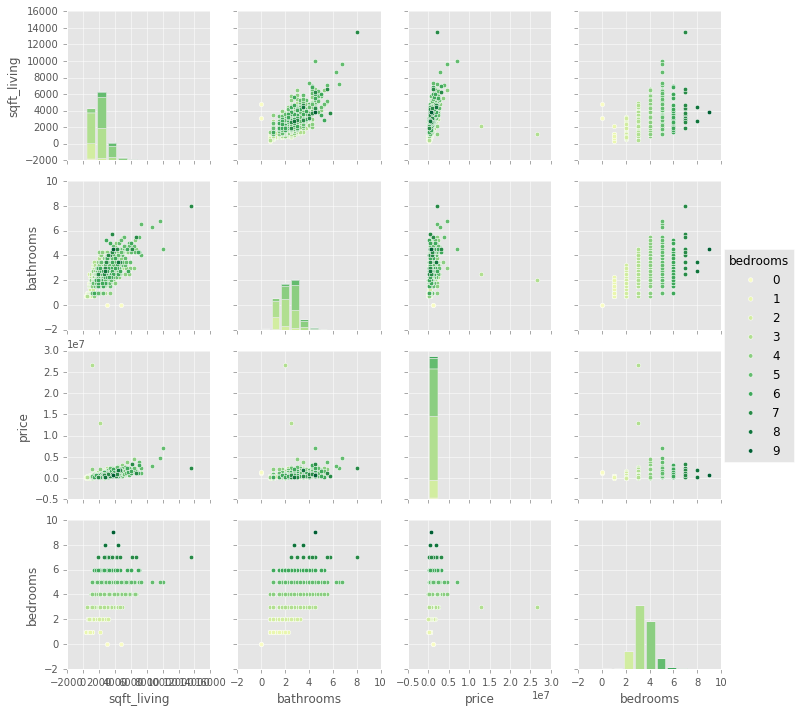

In [32]:
plt.figure(figsize = (10, 15))
sns.pairplot(df_priceDropNa[['sqft_living','bathrooms','price','bedrooms']],hue='bedrooms', palette='YlGn')

#### e. Scatter plot for 'price' with 'sqft_living':

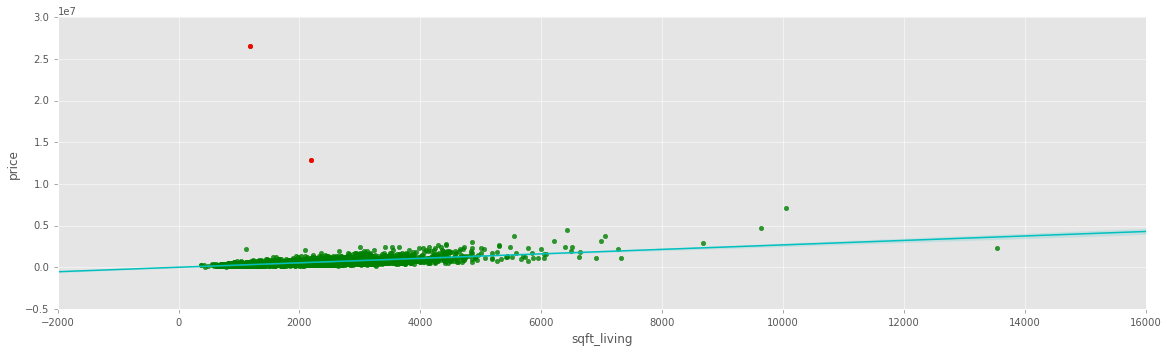

In [33]:
# Scatter plot with linear regression line
g = sns.lmplot(x= 'sqft_living', y='price', data= df_priceDropNa, fit_reg=True,\
               scatter_kws={'color': 'g'}, line_kws={'color': 'c'})
g.fig.set_size_inches(20,5)

# showing 2 points in red color as the 2 outliers in 'price' in the dataset 
outliers = df_priceDropNa[df_priceDropNa.price >10000000]
plt.scatter(x= 'sqft_living', y='price',data=outliers, color='r')

### Note:    
* 'sqft_living' has the highest correlation with 'price' follow by 'sqft_above' and 'bathrooms'.
* By seeing the relation between 'price' with 'sqft_living', we noted that the two extreme value of the price are outliers in the dataset as these two values in price are extremely higher than others which with the same 'sqft_living' values. (See points in red in the plot above)
* In the scatter plot above, seems like the 2 outliers doesn't have much impact of the linear regression of the price prediction model. However, to be safe, we will still remove it temporarily from the dataset to avoid any impact when using linear regression to make the model of price prediction. (We will not remove the outlier for good, just exclude them when creating a new dataframe.)

#### f. New dataframe without 2 outliers in 'price':

In [34]:
df_priceDropNa_outLiers = df_priceDropNa[df_priceDropNa.price <10000000]

#### g. Misc.: outliers for 'sqft_lot':

In [35]:
df_priceDropNa_outLiers[df_priceDropNa_outLiers.sqft_lot >600000]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
1078,20140521T000000,542500.0,5,3.25,3010.0,1074218.0,1.5,0,0,5,2010,1000,1931,NaN,16200-16398 252nd Ave SE,Issaquah,WA 98027,USA
2480,20140613T000000,849900.0,2,2.00,2280.0,641203.0,2.0,0,0,3,2280,0,1990,NaN,9326 SW 216th St,Vashon,WA 98070,USA


### Note:  
* The two records with much larger space of property land compared with others in the dataset.
* However, we noted from the correlation relationship table, correlation between 'sqft_lot' and 'price' is very little that it won't affect our regression model for the price prediction. So, we decided to keep the 2 outliers of 'sqft_lot' in the dataframe.

## 2.8 Missing values

### 2.8-1 Missing value in yr_renovated:

In [36]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4601 entries, 0 to 4600
Data columns (total 18 columns):
date             4601 non-null object
price            4601 non-null float64
bedrooms         4601 non-null int64
bathrooms        4601 non-null float64
sqft_living      4601 non-null float64
sqft_lot         4601 non-null float64
floors           4601 non-null float64
waterfront       4601 non-null int64
view             4601 non-null int64
condition        4601 non-null int64
sqft_above       4601 non-null int64
sqft_basement    4601 non-null int64
yr_built         4601 non-null int64
yr_renovated     229 non-null float64
street           4601 non-null object
city             4601 non-null object
statezip         4601 non-null object
country          4601 non-null object
dtypes: float64(6), int64(7), object(5)
memory usage: 647.1+ KB


#### Note:  
* Total 4372 records, the value of 'yr_renovated' are NaN.
* For those records, we have not idea that it is a missing input or it means the property have never been renovated.
* As 'yr_renovated' has very little correlation to 'price', we are not going to add 'yr_renovated' as a feature in our price prediction model. We remain the NaN value for those records in the dataset.

In [37]:
# For'yr_renovated', correlation to 'price' is cosidered very little 
print(df[['yr_renovated','price']].corr())

              yr_renovated     price
yr_renovated      1.000000  0.123859
price             0.123859  1.000000


### 2.8-2 Records with no bedroom and bathroom are not missing value.

In [38]:
df_priceDropNa_outLiers[(df_priceDropNa_outLiers.bedrooms == 0) | (df_priceDropNa_outLiers.bathrooms == 0)]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
2365,20140612T000000,1095000.0,0,0.0,3064.0,4764.0,3.5,0,2,3,3064,0,1990,NaN,814 E Howe St,Seattle,WA 98102,USA
3209,20140624T000000,1295648.0,0,0.0,4810.0,28008.0,2.0,0,0,3,4810,0,1990,NaN,20418 NE 64th Pl,Redmond,WA 98053,USA


### Note:  
* 2 records with no bedrooms and bathrooms.
* Is there any missing value? 
* As the installation, inside of the house can be take down without any further renovation which means an empty house or even no house on the land. It is reasonable to have no bedroom and bathroom in a property sold record. Hence, it is considered a missing value exist in the above 2 records.

### 2.8-3 Records with sale price zero are missing value in 'price':

#### a. In the raw dataset, there are 248 records with price == 0 which are considered missing value in 'price':

In [39]:
df_raw.price[(df_raw.price == 0)].count()

248

#### b. Dataset we create without no missing values and outliers in 'price':

In [40]:
df_priceDropNa_outLiers.price[(df_priceDropNa_outLiers.price == 0)].count()

0

### Note:  
* We will use this dataset which have excluded records with missing values in 'price' to build the regression model.
* The model will be used to make the prediction of the 'price' for those missing value records

## 2.9 Select features for regression model for predicting sale prices

In [41]:
#check correlation with 'price'
df_priceDropNa_outLiers.corr()[['price']].sort_values(by='price', ascending=False)

,price
price,1.000000
sqft_living,0.709214
sqft_above,0.608224
bathrooms,0.525026
view,0.389557
sqft_basement,0.344130
bedrooms,0.332886
floors,0.255650
waterfront,0.237912
yr_renovated,0.125601


### Note:  
* By removing the missing value records and outliers for 'price', we can see that the correlation for variable to 'price' rise. We noted that outliers and missing values do have some impact that decrease the normality of a dataset.
* We selected those features have some degree of correlation to the 'price' as below:
 1. sqft_living
 2. bathrooms
 3. view
 4. bedrooms
 5. floors
 6. waterfront
* We may also want to know that if 'place' affect the property price.

#### a. Add a feature 'pricePerSqftLiving':

In [42]:
#Safely disable SettingWithCopyWarning (to disable the warning appears when assigning new value to replace the old value)
#revised value and the dataframe will not be effected.
pd.options.mode.chained_assignment = None

#Add feature 'pricePerSqftLiving'
df_priceDropNa_outLiers.loc[:,'pricePerSqftLiving'] = df_priceDropNa_outLiers['price']/df_priceDropNa_outLiers['sqft_living']
df_priceDropNa_outLiers.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country,pricePerSqftLiving
0,20140502T000000,313000.0,3,1.50,1340.0,7912.0,1.5,0,0,3,1340,0,1955,NaN,18810 Densmore Ave N,Shoreline,WA 98133,USA,233.582090
1,20140502T000000,2384000.0,5,2.50,3650.0,9050.0,2.0,0,4,5,3370,280,1921,NaN,709 W Blaine St,Seattle,WA 98119,USA,653.150685
2,20140502T000000,342000.0,3,2.00,1930.0,11947.0,1.0,0,0,4,1930,0,1966,NaN,26206-26214 143rd Ave SE,Kent,WA 98042,USA,177.202073
3,20140502T000000,420000.0,3,2.25,2000.0,8030.0,1.0,0,0,4,1000,1000,1963,NaN,857 170th Pl NE,Bellevue,WA 98008,USA,210.000000
4,20140502T000000,550000.0,4,2.50,1940.0,10500.0,1.0,0,0,4,1140,800,1976,NaN,9105 170th Ave NE,Redmond,WA 98052,USA,283.505155


#### b. Plot boxplot to see the price per square foot of living  by 'statezip':

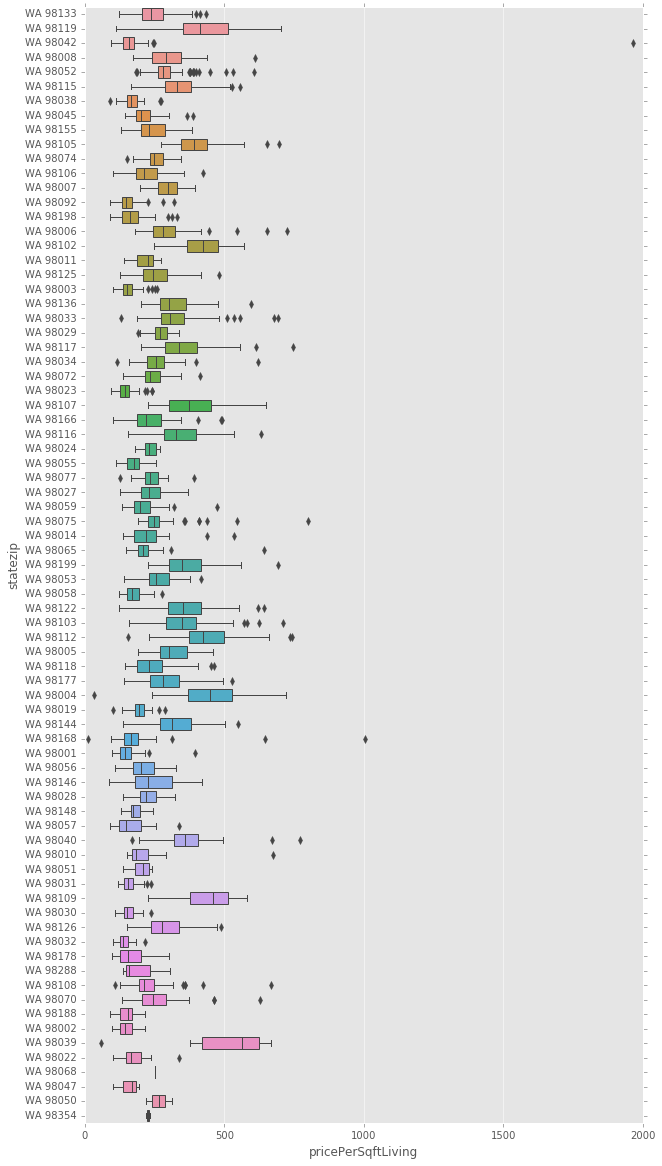

In [43]:
plt.figure(figsize = (10, 20))
sns.boxplot( x = 'pricePerSqftLiving', y='statezip', data = df_priceDropNa_outLiers ,orient='h')

### Note: 
* Some places have higher price per square footage to the other places in Washington state, USA.
* 'statezip' may be a good feature to add in making the house prediction model. But the 'statzip' is categorical type. We cannot directly use it to the regression model.
* Hence, we decided to create a numerical datatype feature, the feature is the midian value of pricePerSqftLiving for each 'statezip'. This feature represents the correlation between the 'statezip' and 'price'.

#### c. Add cloumn: price per square foot living by 'statezip':

In [44]:
df_priceDropNa_outLiers.loc[:,'med_pricePerSqftLiving_sateZip']\
= df_priceDropNa_outLiers.pricePerSqftLiving.groupby(df_priceDropNa_outLiers['statezip']).transform('median')
df_priceDropNa_outLiers.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country,pricePerSqftLiving,med_pricePerSqftLiving_sateZip
0,20140502T000000,313000.0,3,1.50,1340.0,7912.0,1.5,0,0,3,1340,0,1955,NaN,18810 Densmore Ave N,Shoreline,WA 98133,USA,233.582090,236.196319
1,20140502T000000,2384000.0,5,2.50,3650.0,9050.0,2.0,0,4,5,3370,280,1921,NaN,709 W Blaine St,Seattle,WA 98119,USA,653.150685,410.635359
2,20140502T000000,342000.0,3,2.00,1930.0,11947.0,1.0,0,0,4,1930,0,1966,NaN,26206-26214 143rd Ave SE,Kent,WA 98042,USA,177.202073,156.451613
3,20140502T000000,420000.0,3,2.25,2000.0,8030.0,1.0,0,0,4,1000,1000,1963,NaN,857 170th Pl NE,Bellevue,WA 98008,USA,210.000000,291.935484
4,20140502T000000,550000.0,4,2.50,1940.0,10500.0,1.0,0,0,4,1140,800,1976,NaN,9105 170th Ave NE,Redmond,WA 98052,USA,283.505155,280.000784


#### d. Check correlation with 'price':

In [45]:
df_priceDropNa_outLiers.corr()[['price']].sort_values(by='price', ascending=False)

,price
price,1.000000
sqft_living,0.709214
sqft_above,0.608224
pricePerSqftLiving,0.541911
med_pricePerSqftLiving_sateZip,0.538899
bathrooms,0.525026
view,0.389557
sqft_basement,0.344130
bedrooms,0.332886
floors,0.255650


### Note:
Finalise features for regression model:
 1. bedrooms
 2. bathrooms
 3. sqft_living
 4. floors
 5. waterfront
 6. view
 7. med_pricePerSqftLiving_sateZip

## T2.10 Build the regression model 
We are using total 7 features that the correlation coefficient with 'price' are above 0.2 which considered have some degress of relation to the 'price' to build the regression model:
* 'bedrooms', 'bathrooms', 'sqft_living', 'floors', 'waterfront', 'view', 'med_pricePerSqftLiving_sateZip'

### 2.10-1 Model using cleaned dataset

In [46]:
# build model
features = ['date','sqft_lot','condition','sqft_above',\
             'sqft_basement','yr_built','yr_renovated',\
             'street', 'city', 'statezip','country', 'pricePerSqftLiving']
lm_cleand_df = df_priceDropNa_outLiers.drop(features,axis=1) 

X_train, X_test, y_train, y_test =\
train_test_split(lm_cleand_df.iloc[:,1:],lm_cleand_df.iloc[:,0:1],random_state=111)
map(pd.np.shape,[X_train, X_test, y_train, y_test])

lm_cleand = LinearRegression()
lm_cleand.fit(X_train,y_train)
print 'r-squared for this model = ',lm_cleand.score(X_test,y_test)

r-squared for this model =  0.757887371375


### 2.10-2 Model using raw data

In [47]:
# add column med_pricePerSqftLiving_sateZip with data to dataframe
med_pricePerSqftLiving_sateZip = df_priceDropNa_outLiers.groupby(df_priceDropNa_outLiers.statezip)[['pricePerSqftLiving']].median()

left = df_raw.copy()
right = med_pricePerSqftLiving_sateZip
df_raw_new = left.join(right, on='statezip')
df_raw_new.rename(columns = {'pricePerSqftLiving':'med_pricePerSqftLiving_sateZip'}, inplace= True)
df_raw_new.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country,med_pricePerSqftLiving_sateZip
0,20140502T000000,313000.0,3,1.50,1340.0,7912.0,1.5,0,0,3,1340,0,1955,NaN,18810 Densmore Ave N,Shoreline,WA 98133,USA,236.196319
1,20140502T000000,2384000.0,5,2.50,3650.0,9050.0,2.0,0,4,5,3370,280,1921,NaN,709 W Blaine St,Seattle,WA 98119,USA,410.635359
2,20140502T000000,342000.0,3,2.00,1930.0,11947.0,1.0,0,0,4,1930,0,1966,NaN,26206-26214 143rd Ave SE,Kent,WA 98042,USA,156.451613
3,20140502T000000,420000.0,3,2.25,2000.0,8030.0,1.0,0,0,4,1000,1000,1963,NaN,857 170th Pl NE,Bellevue,WA 98008,USA,291.935484
4,20140502T000000,550000.0,4,2.50,1940.0,10500.0,1.0,0,0,4,1140,800,1976,NaN,9105 170th Ave NE,Redmond,WA 98052,USA,280.000784


In [48]:
# build model by using raw data
features01 = ['date','sqft_lot','condition','sqft_above',\
             'sqft_basement','yr_built','yr_renovated',\
             'street', 'city', 'statezip','country']
lm_raw_df = df_raw_new.drop(features01,axis=1) 

X_train, X_test, y_train, y_test =\
train_test_split(lm_raw_df.iloc[:,1:],lm_raw_df.iloc[:,0:1],random_state=111)
map(pd.np.shape,[X_train, X_test, y_train, y_test])

lm_raw = LinearRegression()
lm_raw.fit(X_train,y_train)
print 'r-squared for this model = ',lm_raw.score(X_test,y_test)

r-squared for this model =  0.277064384424


### 2.10-3 Predicting the price with cleaned dataset including the two outliers

In [49]:
# add column med_pricePerSqftLiving_sateZip with data to dataframe
left = df_priceDropNa.copy()
right = med_pricePerSqftLiving_sateZip
df_priceDropNa_new = left.join(right, on='statezip')
df_priceDropNa_new.rename(columns = {'pricePerSqftLiving':'med_pricePerSqftLiving_sateZip'}, inplace= True)
df_priceDropNa_new.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country,med_pricePerSqftLiving_sateZip
0,20140502T000000,313000.0,3,1.50,1340.0,7912.0,1.5,0,0,3,1340,0,1955,NaN,18810 Densmore Ave N,Shoreline,WA 98133,USA,236.196319
1,20140502T000000,2384000.0,5,2.50,3650.0,9050.0,2.0,0,4,5,3370,280,1921,NaN,709 W Blaine St,Seattle,WA 98119,USA,410.635359
2,20140502T000000,342000.0,3,2.00,1930.0,11947.0,1.0,0,0,4,1930,0,1966,NaN,26206-26214 143rd Ave SE,Kent,WA 98042,USA,156.451613
3,20140502T000000,420000.0,3,2.25,2000.0,8030.0,1.0,0,0,4,1000,1000,1963,NaN,857 170th Pl NE,Bellevue,WA 98008,USA,291.935484
4,20140502T000000,550000.0,4,2.50,1940.0,10500.0,1.0,0,0,4,1140,800,1976,NaN,9105 170th Ave NE,Redmond,WA 98052,USA,280.000784


In [50]:
# build model by using cleaned dataset including the two outliers
features01 = ['date','sqft_lot','condition','sqft_above',\
             'sqft_basement','yr_built','yr_renovated',\
             'street', 'city', 'statezip','country']
lm_priceDropNa_df = df_priceDropNa_new.drop(features01,axis=1) 

X_train, X_test, y_train, y_test =\
train_test_split(lm_priceDropNa_df.iloc[:,1:],lm_priceDropNa_df.iloc[:,0:1],random_state=111)
map(pd.np.shape,[X_train, X_test, y_train, y_test])

lm_priceDropNa = LinearRegression()
lm_priceDropNa.fit(X_train,y_train)
print 'r-squared for this model = ',lm_priceDropNa.score(X_test,y_test)

r-squared for this model =  0.74605667323


### Note: 
* Compare the performance of this model with the imputed and complete models:

  1. r-squared for model using cleaned data without outliers:  0.757887371375
  2. r-squared for model using raw data:                       0.277064384424
  3. r-squared for model using cleaned data with outliers:     0.74605667323
  
  
* Model build from using cleaned data have a much higher percentage of R-squared. 
* The two outliers have little effect on the changing of R-squared.
* As the model build from using cleaned data without outlier has the highest R-squared that has the highest percentage of the response variable variation that is explained, we are using this model to make the prediction of the 'price' for the missing value in the next step.

## 2.11 Predicting prices for missing value
#### a. Use regression model builded from cleaned dataset and to get the prediction of  'price' value for those records with value zero in 'price':

In [51]:
# As we need median value of price per square foot living by satezip as one of the features
# to predict the price for the missing value. 
# We add data for each record in the final dataframe.
# The final dataframe is a cleaned data with keeping outliers and missing value of price record inside.
left = df.copy()
right = med_pricePerSqftLiving_sateZip
df_fn = left.join(right, on='statezip')
df_fn.rename(columns = {'pricePerSqftLiving':'med_pricePerSqftLiving_sateZip'}, inplace= True)
df_fn.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country,med_pricePerSqftLiving_sateZip
0,20140502T000000,313000.0,3,1.50,1340.0,7912.0,1.5,0,0,3,1340,0,1955,NaN,18810 Densmore Ave N,Shoreline,WA 98133,USA,236.196319
1,20140502T000000,2384000.0,5,2.50,3650.0,9050.0,2.0,0,4,5,3370,280,1921,NaN,709 W Blaine St,Seattle,WA 98119,USA,410.635359
2,20140502T000000,342000.0,3,2.00,1930.0,11947.0,1.0,0,0,4,1930,0,1966,NaN,26206-26214 143rd Ave SE,Kent,WA 98042,USA,156.451613
3,20140502T000000,420000.0,3,2.25,2000.0,8030.0,1.0,0,0,4,1000,1000,1963,NaN,857 170th Pl NE,Bellevue,WA 98008,USA,291.935484
4,20140502T000000,550000.0,4,2.50,1940.0,10500.0,1.0,0,0,4,1140,800,1976,NaN,9105 170th Ave NE,Redmond,WA 98052,USA,280.000784


#### b. Build the regression model:

In [52]:
lm_price = LinearRegression() #instatiate
lm_price.fit(lm_cleand_df[[x for x in lm_cleand_df.columns if x != 'price']],lm_cleand_df['price']) #fit

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

#### c. Model used to predict 'price' for missing value in the dataset. The missing value which are those zero value of 'price' records, the zero value will be replaced by the predicted prices:

In [53]:
features02 = ['date','price','sqft_lot','condition','sqft_above',\
             'sqft_basement','yr_built','yr_renovated',\
             'street', 'city', 'statezip','country']

df_fn['price'][df_fn['price']==0] = lm_price.predict(df_fn.drop(features02,axis=1))
df_fn.price = df_fn.price.round(1)
df_fn.tail()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country,med_pricePerSqftLiving_sateZip
4596,20140709T000000,360956.2,3,1.75,1510.0,6360.0,1.0,0,0,4,1510,0,1954,NaN,501 N 143rd St,Seattle,WA 98133,USA,236.196319
4597,20140709T000000,462921.9,3,2.50,1460.0,7573.0,2.0,0,0,3,1460,0,1983,NaN,14855 SE 10th Pl,Bellevue,WA 98007,USA,299.073964
4598,20140709T000000,640184.8,3,2.50,3010.0,7014.0,2.0,0,0,3,3010,0,2009,NaN,759 Ilwaco Pl NE,Renton,WA 98059,USA,196.653255
4599,20140710T000000,309670.7,4,2.00,2090.0,6630.0,1.0,0,0,3,1070,1020,1974,NaN,5148 S Creston St,Seattle,WA 98178,USA,156.028369
4600,20140710T000000,162520.4,3,2.50,1490.0,8102.0,2.0,0,0,4,1490,0,1990,NaN,18717 SE 258th St,Covington,WA 98042,USA,156.451613


#### d. To drop the unwanted column 'med_pricePerSqftLiving_sateZip'.

In [54]:
df_fn.drop(['med_pricePerSqftLiving_sateZip'], axis=1, inplace= True)
df_fn.tail()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
4596,20140709T000000,360956.2,3,1.75,1510.0,6360.0,1.0,0,0,4,1510,0,1954,NaN,501 N 143rd St,Seattle,WA 98133,USA
4597,20140709T000000,462921.9,3,2.50,1460.0,7573.0,2.0,0,0,3,1460,0,1983,NaN,14855 SE 10th Pl,Bellevue,WA 98007,USA
4598,20140709T000000,640184.8,3,2.50,3010.0,7014.0,2.0,0,0,3,3010,0,2009,NaN,759 Ilwaco Pl NE,Renton,WA 98059,USA
4599,20140710T000000,309670.7,4,2.00,2090.0,6630.0,1.0,0,0,3,1070,1020,1974,NaN,5148 S Creston St,Seattle,WA 98178,USA
4600,20140710T000000,162520.4,3,2.50,1490.0,8102.0,2.0,0,0,4,1490,0,1990,NaN,18717 SE 258th St,Covington,WA 98042,USA


## 2.12 Generate CSV file containing the cleaned data.

In [59]:
#Write final data to a new csv file.
output_file = open ("HSU_28397371_ass2_data.csv", "w+")  
df_fn.to_csv(output_file,index= False)

output_file.close()

------------------------------
# Conclusion:

In this assignment---

Firstly, we did the parsing for the raw data in Task 1. 

Secondly, auditing and cleansing the loaded data in the Task 2 that identifying the mistake in the raw data and fixing them including:

* Lexical errors in city name
* Inconsistency in city name
* Irregularities in date and bathrooms format
* Violations of the Integrity constraint in

  1. sqft_living = sqft_above + sqft_basement
  2. yr_built < yr_renovated
  
  
* Duplications in a record
* Outliers in two records with extreme high figure in 'price'

Third, in missing value, we have found that there are many records with price are zero which is not reasonable that considered missing value in price, so that we built regression model by using selected features in the dataset to make prediction of the price and replacing the zero value by the predicted value from model. 

Finally, we out put the cleaned data to a CSV file that:
* Mistakes and problem in data all fixed
* Outlier in data detected but not removed
* Missing values in data 'price' are replaced by the predicted values
to finished the tasks.

The end.